# NEURAL NETWORK
A manga can be labeled with more than one genre, so it's a multilabel classification.
First the plots are cleaned, then only the top genres are selected for the training.


In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import ast
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rosario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
STOPWORDS = set(stopwords.words('english'))

In [3]:
df = pd.read_csv("mangadb.csv", sep = ";", encoding='utf-8', index_col=0)
df['Genre'] = df['Genre'].apply(ast.literal_eval)
df.dropna(subset = ['Plot'], inplace = True)
genre_count = df['Genre'].apply(pd.Series).stack().value_counts()


In [4]:
#only keeps genres with a count of over 400
threshold = 400
df_genres = genre_count.to_frame().reset_index()
df_genres.columns = ['Genre', 'Count']
df_genres_top = (df_genres[df_genres['Count'] > threshold])
list_genres_top = list(df_genres_top['Genre'])
df_top = pd.DataFrame()

#dataframe cleaning
for index, row in df.iterrows():
    plot = row['Plot']
    for word in STOPWORDS:
        token = ' ' + word + ' '
        plot = plot.replace(token, ' ').replace(' ', ' ')
    df.at[index, 'Plot'] = plot.replace("\n", " ").replace("\r", " ").replace("\\", " ")
    list_permitted = []
    for gen in row['Genre']:
        if gen in list_genres_top:
            list_permitted.append(gen)
    if len(list_permitted) != 0: 
        df.at[index, 'Genre'] = list_permitted
    else:
        df.drop(index, inplace=True)
df.reset_index(drop=True, inplace=True)


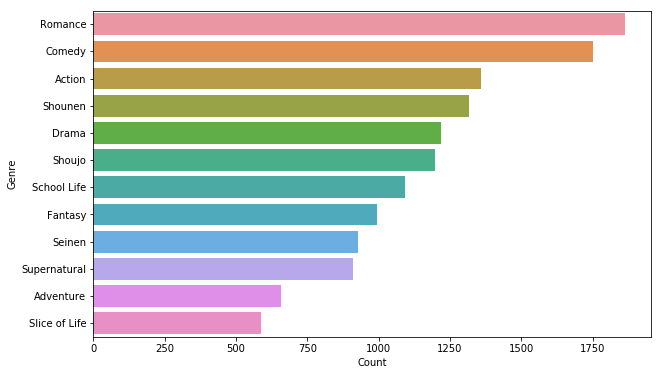

In [5]:
genre_count_top = df['Genre'].apply(pd.Series).stack().value_counts()
df_genres_top = genre_count_top.to_frame().reset_index()
df_genres_top.columns = ['Genre', 'Count']
plt.figure(figsize=(10,6)) 
ax = sns.barplot(data=df_genres_top, x= "Count", y = "Genre") 
plt.show()

In [6]:
train_genres = df['Genre']
train_plot = df['Plot']

The labels are transformed in multi-hot vectors, then the plot sequences are padded (so they have all the same length).

In [7]:
encoder = MultiLabelBinarizer()
encoder.fit_transform(train_genres)
y = encoder.transform(train_genres)
num_classes = len(encoder.classes_)

# Print all possible genres and the labels for the first manga in the dataset
print(encoder.classes_)
print(y[0])

['Action' 'Adventure' 'Comedy' 'Drama' 'Fantasy' 'Romance' 'School Life'
 'Seinen' 'Shoujo' 'Shounen' 'Slice of Life' 'Supernatural']
[0 0 1 1 0 0 1 0 0 1 0 0]


In [8]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_plot))
list_tokenized_train = tokenizer.texts_to_sequences(train_plot)


In [9]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)

In [10]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

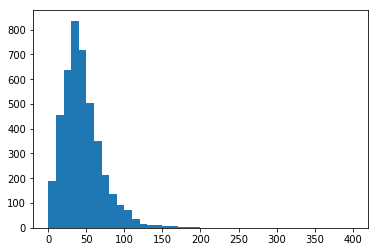

In [11]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [12]:
inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(12, activation="sigmoid")(x)

In [13]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [14]:
batch_size = 32
epochs = 3
history = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 3870 samples, validate on 430 samples
Epoch 1/3
3870/3870 [==============================] - 12s 3ms/sample - loss: 0.5841 - accuracy: 0.7144 - val_loss: 0.5646 - val_accuracy: 0.7335
Epoch 2/3
3870/3870 [==============================] - 10s 3ms/sample - loss: 0.5647 - accuracy: 0.7319 - val_loss: 0.5601 - val_accuracy: 0.7407
Epoch 3/3
3870/3870 [==============================] - 10s 3ms/sample - loss: 0.5388 - accuracy: 0.7426 - val_loss: 0.5270 - val_accuracy: 0.7502


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

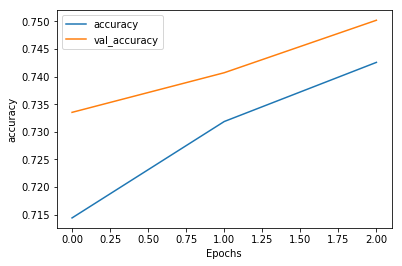

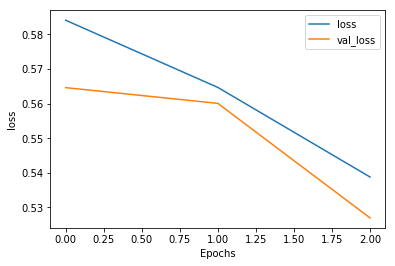

In [16]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [17]:
test_txt = input("Write a story here (English):\n")
tokenized_test_txt = tokenizer.texts_to_sequences(test_txt)
X_test = pad_sequences(tokenized_test_txt, maxlen=maxlen)

Write a story here (English):
Ichigo Kurosaki has always been able to see ghosts, but this ability does not change his life nearly as much as his close encounter with Rukia Kuchiki, a Soul Reaper and member of the mysterious Soul Society. While fighting a Hollow, an evil spirit that preys on humans who display psychic energy, Rukia attempts to lend Ichigo some of her powers so that he can save his family; but much to her surprise, Ichigo absorbs every last drop of her energy. Now a full-fledged Soul Reaper himself, Ichigo quickly learns that the world he inhabits is one full of dangerous spirits and, along with Rukia--who is slowly regaining her powers--it is Ichigos job to protect the innocent from Hollows and help the spirits themselves find peace


In [18]:
pred = model.predict(X_test)
pred2 = pred[0]
enc_list = encoder.classes_.tolist()
pred_list = pred2.tolist()

In [19]:
prob_df  = pd.DataFrame()
prob_df['Predicted Genre'] = enc_list
prob_df['Score'] = pred_list
prob_df.sort_values("Score", ascending= False, inplace=True)

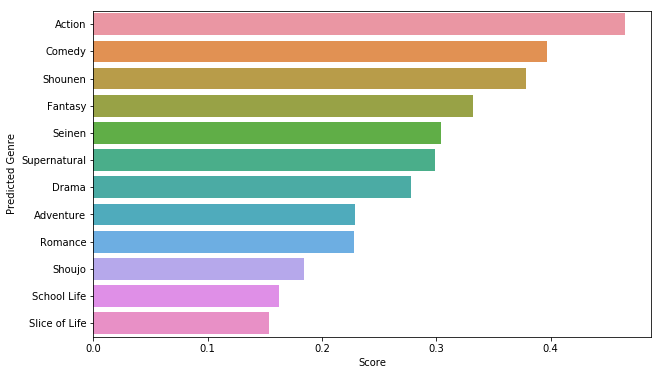

In [20]:
plt.figure(figsize=(10,6)) 
ax = sns.barplot(data=prob_df, x= 'Score', y = 'Predicted Genre') 
plt.show()